In [1]:
# 기본 세팅
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import gaussian_kde
from matplotlib import colors as mpl_colors
import os
import argparse
from datetime import datetime
from glob import glob
from itertools import product, groupby
from mpl_toolkits.mplot3d import Axes3D
import re

In [2]:
# font = {'family': 'Tahoma'}
# font = {'family': 'Times New Roman'}

# plt.rc('font', **font)

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

### Options

In [3]:
save_formats = ['png', 'pdf', 'svg']
device = 'nano'
max_cores = 4
models = ['densenet201']

In [4]:
def LayerNum(model):
    if model == "densenet201" :
        return 306
    elif model == "resnet152" :
        return 206
    elif model == "enetb0" :
        return 136
    elif model == "csmobilenet-v2" :
        return 81
    elif model == "squeezenet" :
        return 50
    elif model == "yolov7" :
        return 143
    elif model == "yolov7-tiny" :
        return 99
    elif model == "yolov4" :
        return 162
    elif model == "yolov4-tiny" :
        return 38
    elif model == "resnet10" :
        return 17
    elif model == "yolov2-tiny" :
        return 16
    else :
        print("Unknown model: ", model)
        return 0
    
for model in models:
    for save_format in save_formats:
        directory_path = f'./{model}/{save_format}'
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)
            print(f"디렉터리 '{directory_path}' 생성 완료!")
        else:
            print(f"디렉터리 '{directory_path}'가 이미 존재합니다.")

디렉터리 './densenet201/png' 생성 완료!
디렉터리 './densenet201/pdf' 생성 완료!
디렉터리 './densenet201/svg' 생성 완료!


### Load csv & Dataframe 생성

In [5]:
## Option ##

model = 'densenet201'
date = 'data-0106'

In [6]:
## Path ##
 
gpu_file_path = f"../../csv/{date}/layer_time/{model}/gpu_raw_data.csv"
cpu_file_path = f"../../csv/{date}/layer_time/{model}/cpu_raw_data_01blas.csv"

# Toy model & Real model

In [7]:
set_model = "real"     # toy, real
target_mode = 2    # 0, 1, 2, 3

if set_model == "toy": num_thread = 10
elif set_model == "real": num_thread = 8
else: print("SetModel!!!!!!\n")

if set_model == "toy": mode_list = ["GPU >>> CPU", "GPU >> CPU", "GPU > CPU", "GPU > CPU | GPU < CPU"]
elif set_model == "real": mode_list = ["yolov7-tiny", "densenet201", "enetb0"]
else: print("Unknown set_model")

mode = mode_list[target_mode]

if set_model == "toy":
    e_preprocess = 10
    e_postprocess = 10

    if mode == "GPU >>> CPU":
        # GPU >>> CPU
        cpu_inference_list = [200,400,350,460,570,330,250,290,310,300]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    if mode == "GPU >> CPU":
        # GPU >>> CPU
        cpu_inference_list = [100,200,150,260,270,130,50,90,110,30]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    elif mode == "GPU > CPU":
        # GPU > CPU
        cpu_inference_list = [10,20,15,26,27,13,5,9,11,3]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    elif mode == "GPU > CPU | GPU < CPU":
        # # GPU CPU 반반 (앞이 GPU 효율 좋음)
        cpu_inference_list = [10,20,15,26,27,13,5,9,11,3]
        gpu_inference_list = [1,3,2,5,7,18,14,15,18,5]
    else: print("Unknown mode")
        
elif set_model == "real": 
    # CSV 파일 경로 설정
    file_path = f'../data/data-0516/sequential-multiblas/{mode}/sequential_01blas.csv'
    
    # CSV 파일 읽기
    df = pd.read_csv(file_path)
    
    e_preprocess = np.mean(df["e_preprocess"])
    e_postprocess = np.mean(df["e_postprocess"])
    
    # 'layer'로 시작하는 모든 열 찾기
    layer_columns = [col for col in df.columns if col.startswith('layer')]
    
    # 각 'layer' 열의 평균 계산
    layer_num = 0
    layer_averages_cpu = {}
    for col in layer_columns:
        # 열 제목에서 숫자만 추출
        col_number = int(re.search(r'\d+', col).group())
        # 해당 열의 평균 계산 및 저장
        layer_averages_cpu[col_number] = df[col].mean()
        if layer_num < col_number : layer_num = col_number
    
    # CSV 파일 경로 설정
    file_path = f'../data/data-0516/layer_time/{mode}/gpu_layer_time.csv'
    
    # CSV 파일 읽기
    df = pd.read_csv(file_path)
    
    # 'layer'로 시작하는 모든 열 찾기
    layer_columns = [col for col in df.columns if col.startswith('layer')]
    
    # 각 'layer' 열의 평균 계산
    layer_num = 0
    layer_averages_gpu = {}
    for col in layer_columns:
        # 열 제목에서 숫자만 추출
        col_number = int(re.search(r'\d+', col).group())
        # 해당 열의 평균 계산 및 저장
        layer_averages_gpu[col_number] = df[col].mean()
        if layer_num < col_number : layer_num = col_number
    
    # CPU와 GPU 인퍼런스 리스트 생성
    cpu_inference_list = list(layer_averages_cpu.values())
    gpu_inference_list = list(layer_averages_gpu.values())

else: print("Unknown!!!")
    
# 거꾸로!!
# cpu_inference_list = cpu_inference_list[::-1]
# gpu_inference_list = gpu_inference_list[::-1]

FileNotFoundError: [Errno 2] No such file or directory: '../data/data-0516/sequential-multiblas/enetb0/sequential_01blas.csv'

# Real model

In [459]:
# model = 'densenet201'

# # CSV 파일 경로 설정
# file_path = f'../data/data-0516/sequential-multiblas/{model}/sequential_01blas.csv'

# # CSV 파일 읽기
# df = pd.read_csv(file_path)

# e_preprocess = np.mean(df["e_preprocess"])
# e_postprocess = np.mean(df["e_postprocess"])

# # 'layer'로 시작하는 모든 열 찾기
# layer_columns = [col for col in df.columns if col.startswith('layer')]

# # 각 'layer' 열의 평균 계산
# layer_num = 0
# layer_averages_cpu = {}
# for col in layer_columns:
#     # 열 제목에서 숫자만 추출
#     col_number = int(re.search(r'\d+', col).group())
#     # 해당 열의 평균 계산 및 저장
#     layer_averages_cpu[col_number] = df[col].mean()
#     if layer_num < col_number : layer_num = col_number

# # 결과 출력
# # print("각 CPU Layer 열의 평균 값 (열 제목은 정수로):")
# # for layer, avg in layer_averages_cpu.items():
# #     print(f"Layer {layer}: {avg}")

# # CSV 파일 경로 설정
# file_path = f'../data/data-0516/layer_time/{model}/gpu_layer_time.csv'

# # CSV 파일 읽기
# df = pd.read_csv(file_path)

# # 'layer'로 시작하는 모든 열 찾기
# layer_columns = [col for col in df.columns if col.startswith('layer')]

# # 각 'layer' 열의 평균 계산
# layer_num = 0
# layer_averages_gpu = {}
# for col in layer_columns:
#     # 열 제목에서 숫자만 추출
#     col_number = int(re.search(r'\d+', col).group())
#     # 해당 열의 평균 계산 및 저장
#     layer_averages_gpu[col_number] = df[col].mean()
#     if layer_num < col_number : layer_num = col_number

# # 결과 출력
# # print("각 GPU Layer 열의 평균 값 (열 제목은 정수로):")
# # for layer, avg in layer_averages_gpu.items():
# #     print(f"Layer {layer}: {avg}")


# # CPU와 GPU 인퍼런스 리스트 생성
# cpu_inference_list = list(layer_averages_cpu.values())
# gpu_inference_list = list(layer_averages_gpu.values())

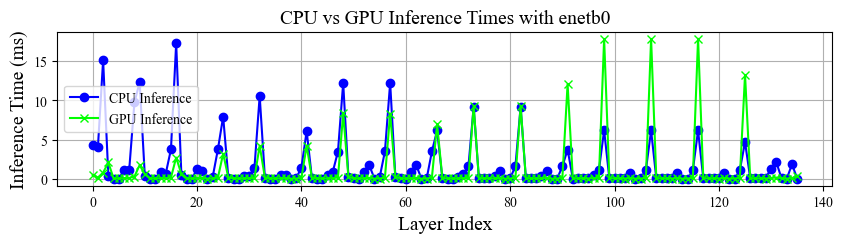

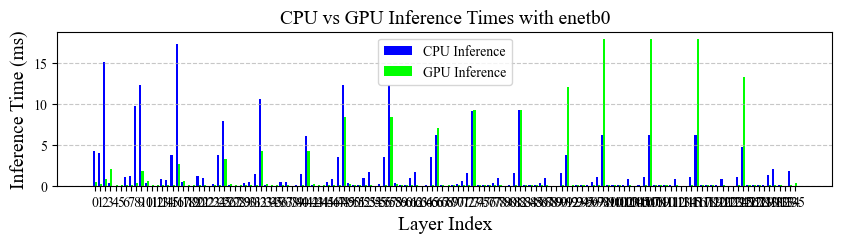

In [461]:
# 그래프 그리기
plt.figure(figsize=(10, 2))
plt.plot(cpu_inference_list, label='CPU Inference', marker='o', linestyle='-', color = 'blue')
plt.plot(gpu_inference_list, label='GPU Inference', marker='x', linestyle='-', color='lime')

# 그래프 제목 및 레이블 설정
plt.title(f'CPU vs GPU Inference Times with {mode}', fontsize=14)
plt.xlabel('Layer Index', fontsize=14)
plt.ylabel('Inference Time (ms)', fontsize=14)
plt.legend()
plt.grid(True)

# 그래프 출력
plt.show()

# 레이어 인덱스 생성
layer_indices = np.arange(len(cpu_inference_list))

# 그래프 그리기
plt.figure(figsize=(10, 2))

# CPU 막대 (연한 노란색)
plt.bar(layer_indices - 0.2, cpu_inference_list, width=0.4, label='CPU Inference', color='blue')

# GPU 막대 (연한 파란색)
plt.bar(layer_indices + 0.2, gpu_inference_list, width=0.4, label='GPU Inference', color='lime')

# 그래프 제목 및 레이블 설정
plt.title(f'CPU vs GPU Inference Times with {mode}', fontsize=14)
plt.xlabel('Layer Index', fontsize=14)
plt.ylabel('Inference Time (ms)', fontsize=14)
plt.xticks(layer_indices)  # X축 인덱스 설정
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Y축 격자만 추가

# 그래프 출력
plt.show()

# Simulation
앞에 num_repeat만큼 값을 빼줘야 반복되는 부분에 대한 확인이 가능함!
end_to_end_delay_list[num_repeat:]

In [463]:
# Preprocess Layer와 Postprocess Layer 앞 뒤에 넣기
layer_num = len(cpu_inference_list)
print(e_preprocess, e_postprocess)
cpu_inference_list.insert(0, e_preprocess)
cpu_inference_list.append(e_postprocess)
gpu_inference_list.insert(0, 0)
gpu_inference_list.append(0)


# acceleration_type 앞 뒤에 CPU (0) 넣기
# [0,M] & [start, M] 구성 찾기
all_results = []
acceleration_type = []

# 모든 start 값에 대한 배열 생성
for start in range(0, 1):
    result = []
    for i in range(start, layer_num):
        row = [0] + [0] * start + [1] * (i - start + 1) + [0] * (layer_num - (i + 1)) + [0]
        result.append(row)
        acceleration_type.append(row)
    all_results.append(result)
# print(acceleration_type)
acceleration_type.sort(key=lambda x: (x.count(1), next((i for i, v in enumerate(x) if v == 1), layer_num+2)))
# print(acceleration_type)

layer_num = len(cpu_inference_list)
print(len(acceleration_type))
print(len(acceleration_type[0]))
print(layer_num)

9.664714285714286 0.01
136
138
138


In [464]:
# # [0,M] & [start, M] 구성 찾기
# all_results = []

# # 모든 start 값에 대한 배열 생성
# for start in range(0, 1):
#     result = []
#     for i in range(start, layer_num-2):
#         row = [0] + [0] * start + [1] * (i - start + 1) + [0] * (layer_num -2 - (i + 1)) + [0]
#         result.append(row)
#     all_results.append(result)

# # 각 배열이 acceleration_type에서 몇 번째 인덱스에 있는지 저장
# all_results_indexes = []

# for result in all_results:

#     result_indexes = []
#     for row in result:
#         # row를 튜플로 변환하여 acceleration_type에서의 인덱스 확인
#         index = acceleration_type.index(tuple(row))
#         result_indexes.append(index)
#     all_results_indexes.append(result_indexes)

In [465]:
# # 새로운 acceleration_type 배열 생성
# new_acceleration_type = []

# # all_results_indexes를 순회
# for result_indexes in all_results_indexes:
#     for index in result_indexes:
#         # acceleration_type의 해당 인덱스를 추가
#         new_acceleration_type.append(acceleration_type[index])

# # 중복 제거 (필요한 경우)
# new_acceleration_type = list(set(new_acceleration_type))
# acceleration_type = new_acceleration_type
# # 결과 확인
# # print(new_acceleration_type)
# print(len(new_acceleration_type))

In [466]:
num_repeat = 100  # 반복 횟수

output_cycle_time = []
output_frame_rate = []
max_execution_time_list = []
min_execution_time_list = []
avg_execution_time_list = []
total_execution_time_list = []
throughput_list = []
acceleration_gain_list = []
block_time_list = []
num_accelerated_layer_list = []

for test_case in range(0, len(acceleration_type)):
    # target_case 가져오기
    target_case = acceleration_type[test_case]
    count_of_ones = target_case.count(1)
    num_accelerated_layer_list.append(count_of_ones)
    # if test_case == 1: print(target_case)
    
    # 연속된 0과 1을 segment 단위로 묶기
    segments = [list(g) for k, g in groupby(target_case)]
    # if test_case == 1: print(segments)
    
    # 각 segment의 delay 및 타입 계산
    segment_delays = []
    segment_types = []
    start_idx = 0
    
    for segment in segments:
        segment_type = segment[0]  # 0 (CPU) 또는 1 (GPU)
        segment_length = len(segment)
        
        # 해당 segment의 delay 계산
        if segment_type == 0:
            delay = sum(cpu_inference_list[start_idx:start_idx + segment_length])
            segment_types.append("cpu")
        else:
            delay = sum(gpu_inference_list[start_idx:start_idx + segment_length])
            segment_types.append("gpu")
        
        segment_delays.append(delay)
        start_idx += segment_length  # 다음 segment의 시작 인덱스 업데이트
    
    # 결과 출력
    # for i, (delay, segment_type) in enumerate(zip(segment_delays, segment_types)):
    #     print(f"Segment {i + 1}: Type = {segment_type}, Delay = {delay}")
    
    segment_type = segment_types
    segment_delay = segment_delays
    
    regular_output_list = []
    total_delay_ = sum(segment_delay)
    
    for input_pattern in range(0, 1):
        data_arrival_interval = input_pattern
    
        task_start_time = [i * data_arrival_interval for i in range(num_thread * num_repeat)]  # [0, 5, 10, 15, 20, 25]
        gpu_available_time = [[[0, float('inf')]] for _ in range(num_thread)]
        segment_end_times = task_start_time[:num_thread]  # 각 스레드의 세그먼트 end_time 초기화
        
        # 시각화를 위한 데이터 수집
        execution_data = {i: [] for i in range(num_thread)}  # 각 스레드의 작업 시작과 끝 시간 저장
        
        for repeat in range(num_repeat):
            # print(f"\nRepeat {repeat + 1} 시작:")
            # 각 세그먼트를 순회
            for k in range(len(segment_type)):
                for i in range(num_thread):
                    # 첫 번째 세그먼트의 시작 시간 조정
                    if k == 0:
                        start_time = max(segment_end_times[i], task_start_time[i + num_thread * repeat])
                    else:
                        start_time = segment_end_times[i]
                        
                    end_time = start_time + segment_delay[k]
        
                    if segment_type[k] == 'gpu':
                        start_time = max(start_time, gpu_available_time[i][0][0])
                        end_time = start_time + segment_delay[k]
        
                        for interval in gpu_available_time[i]:
                            gpu_use_time = end_time - start_time
                            # print(interval[1]-interval[0])
                            if (interval[1]-interval[0]) < gpu_use_time:
                                pass
                            else:
                                start_time = max(start_time, interval[0])
                                end_time = start_time + segment_delay[k]
                                break
                        
                        # 시각화 데이터에 추가
                        execution_data[i].append((start_time, end_time, segment_type[k]))
        
                        
                        # 해당 스레드의 gpu_available_time에서 start_time 이전 값을 삭제
                        new_available_time = []
                        for interval in gpu_available_time[i]:
                            if interval[1] > start_time:
                                if interval[0] < start_time:
                                    new_available_time.append([start_time, interval[1]])
                                else:
                                    new_available_time.append(interval)
                        gpu_available_time[i] = new_available_time
        
                        # 모든 스레드에 대해 gpu_available_time을 업데이트
                        for j in range(num_thread):
                            new_available_time = []
                            for interval in gpu_available_time[j]:
                                if end_time <= interval[0] or start_time >= interval[1]:
                                    new_available_time.append(interval)
                                else:
                                    if interval[0] < start_time:
                                        new_available_time.append([interval[0], start_time])
                                    if interval[1] > end_time:
                                        new_available_time.append([end_time, interval[1]])
                            gpu_available_time[j] = new_available_time
        
                    elif segment_type[k] == 'cpu':
                        # 시각화 데이터에 추가
                        execution_data[i].append((start_time, end_time, segment_type[k]))
        
                        # 현재 스레드의 gpu_available_time에서 end_time 이하의 구간을 삭제
                        new_available_time = []
                        for interval in gpu_available_time[i]:
                            if interval[1] > end_time:
                                if interval[0] < end_time:
                                    new_available_time.append([end_time, interval[1]])
                                else:
                                    new_available_time.append(interval)
                        gpu_available_time[i] = new_available_time
        
                    # 현재 세그먼트의 종료 시간을 기록하여 다음 세그먼트 시작 시간을 결정
                    segment_end_times[i] = end_time
                    # print(f"스레드 {i + 1}의 {segment_type[k]} 세그먼트 후 gpu_available_time:", gpu_available_time)
        
        # 각 스레드의 end_time 기록을 위한 초기화
        thread_end_times = [0] * num_thread  # 각 스레드의 마지막 end_time 기록
        
        # Start time, end time, and end-to-end delay lists 초기화
        release_time_list = []
        start_time_list = []
        end_time_list = []
        end_to_end_delay_list = []
        
        # End-to-end delay 계산 및 리스트에 저장
        for repeat in range(num_repeat):
            for thread in range(num_thread):
                # 각 task의 첫 번째 세그먼트의 start_time과 마지막 세그먼트의 end_time 찾기
                task_segments = execution_data[thread][repeat * len(segment_type):(repeat + 1) * len(segment_type)]
                start_time = task_segments[0][0]
                end_time = task_segments[-1][1]
                end_to_end_delay = end_time - thread_end_times[thread]
                # print(start_time, end_time)
                
                # 리스트에 추가
                release_time_list.append(thread_end_times[thread])
                start_time_list.append(start_time)
                end_time_list.append(end_time)
                end_to_end_delay_list.append(end_to_end_delay)
        
                # 현재 스레드의 마지막 end_time 업데이트
                thread_end_times[thread] = end_time
                
                # print(f"Repeat {repeat + 1}, Thread {thread + 1} - Start: {start_time}, End: {end_time}, End-to-End Delay: {end_to_end_delay}")
        
        # 리스트 출력
        # print("\nRelease Time List:", release_time_list)
        # print("Start Time List:", start_time_list)
        # print("End Time List:", end_time_list)
        # print("End-to-End Delay List:", end_to_end_delay_list)
        
        # Start time gap list와 end time gap list 초기화
        start_time_gap_list = []
        end_time_gap_list = []
        
        # Start time과 end time gap 계산
        for i in range(1, len(release_time_list)):
            start_time_gap = release_time_list[i] - release_time_list[i - 1]
            end_time_gap = end_time_list[i] - end_time_list[i - 1]
            
            start_time_gap_list.append(start_time_gap)
            end_time_gap_list.append(end_time_gap)
            
        max_execution_time_list.append(np.max(end_to_end_delay_list[num_repeat:]))
        min_execution_time_list.append(np.min(end_to_end_delay_list[num_repeat:]))
        avg_execution_time_list.append(np.mean(end_to_end_delay_list[num_repeat:]))
        total_execution_time = end_time_list[-1] - release_time_list[num_repeat]
        # print("here", end_time_list[-1], release_time_list[num_repeat])
        throughput = (num_repeat * num_thread) / total_execution_time * 1000
        total_execution_time_list.append(total_execution_time)
        throughput_list.append(throughput)
        # print(test_case, "-->", end_time_gap_list, end_to_end_delay_list)

        corresponding_acceleration_type = acceleration_type[test_case]

        # 합 계산
        total_inference_time = sum(
            cpu_inference_list[i] if corresponding_acceleration_type[i] == 0 else gpu_inference_list[i]
            for i in range(layer_num)
        )
        
        # blcok loss & acceleration gain
        total_cpu_time = sum(cpu_inference_list)
        acceleration_gain = total_cpu_time - total_inference_time
        acceleration_gain_list.append(acceleration_gain)
        max_execution_time = np.max(end_to_end_delay_list[num_repeat:])
        block_time = max_execution_time-total_inference_time
        block_time_list.append(block_time)
        
        print(test_case, "-->", np.max(end_to_end_delay_list[num_repeat:]), np.min(end_to_end_delay_list[num_repeat:]), np.mean(end_to_end_delay_list[num_repeat:]), "--> total_execution_time:", total_execution_time, "throughput:", throughput)
        print(test_case, total_cpu_time, max_execution_time,total_inference_time, "-->", f"가속 이득: {acceleration_gain} 블락 손실: {block_time}\n")

0 --> 229.9863533835014 229.98635338345048 229.98635338347208 --> total_execution_time: 201241.42488422233 throughput: 39.75324665188858
0 233.76078571428587 229.9863533835014 229.98635338345878 --> 가속 이득: 3.7744323308270964 블락 손실: 4.263256414560601e-11

1 --> 226.1454022556427 226.14540225562814 226.14540225564144 --> total_execution_time: 197881.6612894757 throughput: 40.4282031385264
1 233.76078571428587 226.1454022556427 226.14540225563923 --> 가속 이득: 7.615383458646647 블락 손실: 3.467448550509289e-12

2 --> 211.77960751880892 211.7796075187798 211.77960751879567 --> total_execution_time: 185317.0124315778 throughput: 43.16926921619641
2 233.76078571428587 211.77960751880892 211.7796075187971 --> 가속 이득: 21.98117819548878 블락 손실: 1.1823431123048067e-11

3 --> 213.47455338347936 213.47455338345026 213.47455338346973 --> total_execution_time: 186814.62508422023 throughput: 42.823199716796374
3 233.76078571428587 213.47455338347936 213.47455338345873 --> 가속 이득: 20.286232330827147 블락 손실: 2.06

In [467]:
# test_case = 1023 

# from itertools import product, groupby


# layer_num = len(cpu_inference_list)

# # # 결과 확인
# # for case in acceleration_type:
# #     print(case)

# # 1000번째 케이스 가져오기
# case_1000 = acceleration_type[test_case]

# # 연속된 0과 1을 segment 단위로 묶기
# segments = [list(g) for k, g in groupby(case_1000)]

# # 각 segment의 delay 및 타입 계산
# segment_delays = []
# segment_types = []
# start_idx = 0

# for segment in segments:
#     segment_type = segment[0]  # 0 (CPU) 또는 1 (GPU)
#     segment_length = len(segment)
    
#     # 해당 segment의 delay 계산
#     if segment_type == 0:
#         delay = sum(cpu_inference_list[start_idx:start_idx + segment_length])
#         segment_types.append("cpu")
#     else:
#         delay = sum(gpu_inference_list[start_idx:start_idx + segment_length])
#         segment_types.append("gpu")
    
#     segment_delays.append(delay)
#     start_idx += segment_length  # 다음 segment의 시작 인덱스 업데이트

# # 결과 출력
# # for i, (delay, segment_type) in enumerate(zip(segment_delays, segment_types)):
# #     print(f"Segment {i + 1}: Type = {segment_type}, Delay = {delay}")

# segment_type = segment_types
# segment_delay = segment_delays

# print(len(acceleration_type))
# print(segment_type)
# print(segment_delay)


# import matplotlib.pyplot as plt

# # 주어진 변수들
# data_arrival_interval = 0
# num_thread = 3
# num_repeat = 3  # 반복 횟수
# task_start_time = [i * data_arrival_interval for i in range(num_thread * num_repeat)]  # [0, 5, 10, 15, 20, 25]
# gpu_available_time = [[[0, float('inf')]] for _ in range(num_thread)]
# segment_end_times = task_start_time[:num_thread]  # 각 스레드의 세그먼트 end_time 초기화

# # 시각화를 위한 데이터 수집
# execution_data = {i: [] for i in range(num_thread)}  # 각 스레드의 작업 시작과 끝 시간 저장

# for repeat in range(num_repeat):
#     print(f"\nRepeat {repeat + 1} 시작:")
#     # 각 세그먼트를 순회
#     for k in range(len(segment_type)):
#         for i in range(num_thread):
#             # 첫 번째 세그먼트의 시작 시간 조정
#             if k == 0:
#                 start_time = max(segment_end_times[i], task_start_time[i + num_thread * repeat])
#             else:
#                 start_time = segment_end_times[i]
                
#             end_time = start_time + segment_delay[k]

#             if segment_type[k] == 'gpu':
#                 start_time = max(start_time, gpu_available_time[i][0][0])
#                 end_time = start_time + segment_delay[k]

#                 for interval in gpu_available_time[i]:
#                     gpu_use_time = end_time - start_time
#                     # print(interval[1]-interval[0])
#                     if (interval[1]-interval[0]) < gpu_use_time:
#                         pass
#                     else:
#                         start_time = max(start_time, interval[0])
#                         end_time = start_time + segment_delay[k]
#                         break
                
#                 # 시각화 데이터에 추가
#                 execution_data[i].append((start_time, end_time, segment_type[k]))

                
#                 # 해당 스레드의 gpu_available_time에서 start_time 이전 값을 삭제
#                 new_available_time = []
#                 for interval in gpu_available_time[i]:
#                     if interval[1] > start_time:
#                         if interval[0] < start_time:
#                             new_available_time.append([start_time, interval[1]])
#                         else:
#                             new_available_time.append(interval)
#                 gpu_available_time[i] = new_available_time

#                 # 모든 스레드에 대해 gpu_available_time을 업데이트
#                 for j in range(num_thread):
#                     new_available_time = []
#                     for interval in gpu_available_time[j]:
#                         if end_time <= interval[0] or start_time >= interval[1]:
#                             new_available_time.append(interval)
#                         else:
#                             if interval[0] < start_time:
#                                 new_available_time.append([interval[0], start_time])
#                             if interval[1] > end_time:
#                                 new_available_time.append([end_time, interval[1]])
#                     gpu_available_time[j] = new_available_time

#             elif segment_type[k] == 'cpu':
#                 # 시각화 데이터에 추가
#                 execution_data[i].append((start_time, end_time, segment_type[k]))

#                 # 현재 스레드의 gpu_available_time에서 end_time 이하의 구간을 삭제
#                 new_available_time = []
#                 for interval in gpu_available_time[i]:
#                     if interval[1] > end_time:
#                         if interval[0] < end_time:
#                             new_available_time.append([end_time, interval[1]])
#                         else:
#                             new_available_time.append(interval)
#                 gpu_available_time[i] = new_available_time

#             # 현재 세그먼트의 종료 시간을 기록하여 다음 세그먼트 시작 시간을 결정
#             segment_end_times[i] = end_time
#             print(f"스레드 {i + 1}의 {segment_type[k]} 세그먼트 후 gpu_available_time:", gpu_available_time)

# # 그래프 시각화 (1열 2행 분리, 2번째 그래프에 GPU 사용 시간만 합쳐서 표현)
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
# colors = {'gpu': 'lime', 'cpu': 'skyblue'}
# legend_added = {'gpu': False, 'cpu': False}

# # 1행 1열: 전체 스레드 실행 시간
# for thread, tasks in execution_data.items():
#     for start, end, seg_type in tasks:
#         # 각 세그먼트 유형에 대해 한 번만 범례 추가
#         if not legend_added[seg_type]:
#             ax1.barh(thread + 1, end - start, left=start, color=colors[seg_type], edgecolor='black', label=seg_type)
#             legend_added[seg_type] = True
#         else:
#             ax1.barh(thread + 1, end - start, left=start, color=colors[seg_type], edgecolor='black')

# # 2행: 모든 스레드의 GPU 사용 시간 합쳐서 표현
# for thread, tasks in execution_data.items():
#     for start, end, seg_type in tasks:
#         if seg_type == 'gpu':  # GPU 세그먼트만 표시
#             ax2.barh(1, end - start, left=start, color=colors['gpu'], edgecolor='black')

# # 1행 라벨링
# ax1.set_ylabel("Thread")
# ax1.set_yticks(range(1, num_thread + 1))
# ax1.set_yticklabels([f"Thread {i + 1}" for i in range(num_thread)])
# ax1.invert_yaxis()
# ax1.legend(loc='upper right')
# ax1.set_title("Thread Execution Timeline (All Segments)")

# # 2행 라벨링 (모든 GPU 사용 시간 합쳐서 표시)
# ax2.set_xlabel("Time")
# ax2.set_ylabel("GPU Usage (Aggregated)")
# ax2.set_yticks([1])
# ax2.set_yticklabels(["GPU"])
# ax2.invert_yaxis()
# ax2.set_title("Aggregated GPU Execution Timeline")

# # 공통 설정
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# output_cycle_time = []
# output_frame_rate = []
# max_execution_time_list = []
# min_execution_time_list = []
# avg_execution_time_list = []
# total_execution_time_list = []
# throughput_list = []
# acceleration_gain_list = []
# block_time_list = []

# # 각 스레드의 end_time 기록을 위한 초기화
# thread_end_times = [0] * num_thread  # 각 스레드의 마지막 end_time 기록

# # Start time, end time, and end-to-end delay lists 초기화
# release_time_list = []
# start_time_list = []
# end_time_list = []
# end_to_end_delay_list = []

# # End-to-end delay 계산 및 리스트에 저장
# for repeat in range(num_repeat):
#     for thread in range(num_thread):
#         # 각 task의 첫 번째 세그먼트의 start_time과 마지막 세그먼트의 end_time 찾기
#         task_segments = execution_data[thread][repeat * len(segment_type):(repeat + 1) * len(segment_type)]
#         start_time = task_segments[0][0]
#         end_time = task_segments[-1][1]
#         end_to_end_delay = end_time - thread_end_times[thread]
#         print(start_time, end_time)
        
#         # 리스트에 추가
#         release_time_list.append(thread_end_times[thread])
#         start_time_list.append(start_time)
#         end_time_list.append(end_time)
#         end_to_end_delay_list.append(end_to_end_delay)

#         # 현재 스레드의 마지막 end_time 업데이트
#         thread_end_times[thread] = end_time
        
#         # print(f"Repeat {repeat + 1}, Thread {thread + 1} - Start: {start_time}, End: {end_time}, End-to-End Delay: {end_to_end_delay}")

# # 리스트 출력
# # print("\nRelease Time List:", release_time_list)
# # print("Start Time List:", start_time_list)
# # print("End Time List:", end_time_list)
# # print("End-to-End Delay List:", end_to_end_delay_list)

# # Start time gap list와 end time gap list 초기화
# start_time_gap_list = []
# end_time_gap_list = []

# # Start time과 end time gap 계산
# for i in range(1, len(release_time_list)):
#     start_time_gap = release_time_list[i] - release_time_list[i - 1]
#     end_time_gap = end_time_list[i] - end_time_list[i - 1]
    
#     start_time_gap_list.append(start_time_gap)
#     end_time_gap_list.append(end_time_gap)
    
# max_execution_time_list.append(np.max(end_to_end_delay_list[num_repeat:]))
# min_execution_time_list.append(np.min(end_to_end_delay_list[num_repeat:]))
# avg_execution_time_list.append(np.mean(end_to_end_delay_list[num_repeat:]))
# total_execution_time = end_time_list[-1] - release_time_list[num_repeat]
# print("here", end_time_list[-1], release_time_list[num_repeat])
# throughput = (num_repeat * num_thread) / total_execution_time * 1000
# total_execution_time_list.append(total_execution_time)
# throughput_list.append(throughput)
# # print(test_case, "-->", end_time_gap_list, end_to_end_delay_list)

# corresponding_acceleration_type = acceleration_type[test_case]

# # 합 계산
# total_inference_time = sum(
#     cpu_inference_list[i] if corresponding_acceleration_type[i] == 0 else gpu_inference_list[i]
#     for i in range(layer_num)
# )

# # blcok loss & acceleration gain
# total_cpu_time = sum(cpu_inference_list)
# acceleration_gain = total_cpu_time - total_inference_time
# acceleration_gain_list.append(acceleration_gain)
# max_execution_time = np.max(end_to_end_delay_list[num_repeat:])
# block_time = max_execution_time-total_inference_time
# block_time_list.append(block_time)

# print(test_case, "-->", np.max(end_to_end_delay_list[num_repeat:]), np.min(end_to_end_delay_list[num_repeat:]), np.mean(end_to_end_delay_list[num_repeat:]), "--> total_execution_time:", total_execution_time, "throughput:", throughput)
# print(test_case, total_cpu_time, max_execution_time,total_inference_time, "-->", f"가속 이득: {acceleration_gain} 블락 손실: {block_time}\n")

# GPU-accel [0, M]

MAX Throughput Index: 40
MAX Throughput: 60.27415828821548
Corresponding Number of Accelerated Layers: 41
Corresponding Delay: 151.53799924812483


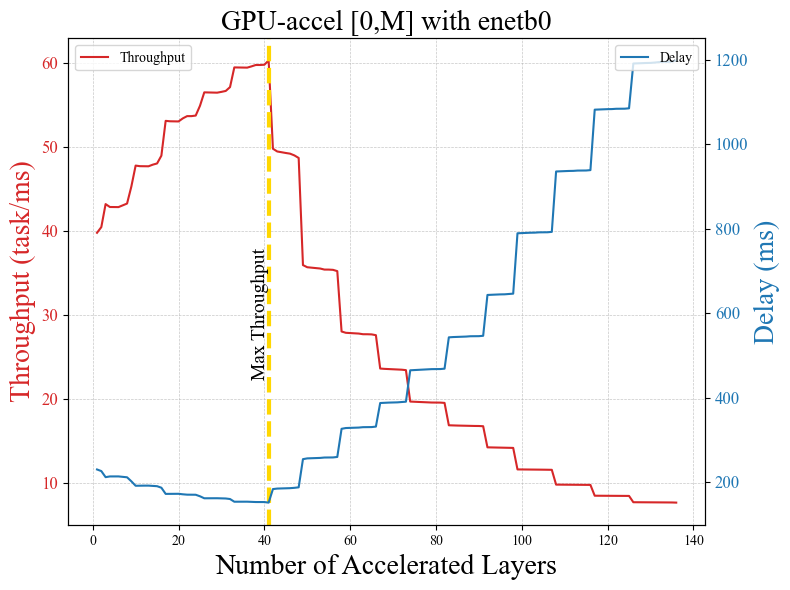

In [469]:
# num_accelerated_layer_list를 기준으로 정렬
sorted_data = sorted(zip(num_accelerated_layer_list, max_execution_time_list, throughput_list))

# 정렬된 데이터 분리
sorted_num_accelerated_layer_list, sorted_max_execution_time_list, sorted_throughput_list = zip(*sorted_data)

# MAX throughput과 그때의 delay 계산 및 출력
max_throughput = max(sorted_throughput_list)
max_throughput_index = sorted_throughput_list.index(max_throughput)
corresponding_delay = sorted_max_execution_time_list[max_throughput_index]
corresponding_delay_num_of_accelerated_layers = sorted_num_accelerated_layer_list[max_throughput_index]

print("MAX Throughput Index:", max_throughput_index)
print("MAX Throughput:", max_throughput)
print("Corresponding Number of Accelerated Layers:", corresponding_delay_num_of_accelerated_layers)
print("Corresponding Delay:", corresponding_delay)


# 2개의 y축을 가지는 그래프 생성
fig, ax1 = plt.subplots(figsize=(8, 6))

# 첫 번째 y축 (total_execution_time_list)
color = "tab:red"
ax1.set_ylabel("Throughput (task/ms)", color=color, size=20)
ax1.set_xlabel("Number of Accelerated Layers", size=20)

ax1.plot(sorted_num_accelerated_layer_list, sorted_throughput_list, color=color, linestyle="-", label="Throughput")
ax1.tick_params(axis="y", labelcolor=color, labelsize=12)
ax1.legend(loc="upper left")

# 두 번째 y축 (throughput_list)
ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_xlabel("Layer index", size=20)
ax2.set_ylabel("Delay (ms)", color=color, size=20)
ax2.plot(sorted_num_accelerated_layer_list, sorted_max_execution_time_list, color=color, linestyle="-", label="Delay")
ax2.tick_params(axis="y", labelcolor=color, labelsize=12)
ax2.legend(loc="upper right")

ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

ax1.axvline(x=corresponding_delay_num_of_accelerated_layers, color="gold", linewidth=3, linestyle="--")
ax1.text(corresponding_delay_num_of_accelerated_layers, np.max(sorted_throughput_list) / 2, "Max Throughput", color="black", rotation=90, 
         verticalalignment="center", horizontalalignment="right", fontsize=14)

plt.title(f"GPU-accel [0,M] with {mode}", size=20)
plt.tight_layout()
plt.show()

# print("num_accelerated_layer_list: ", num_accelerated_layer_list)
# print("max_execution_time_list: ", max_execution_time_list)
# print("throughput_list: ", throughput_list)

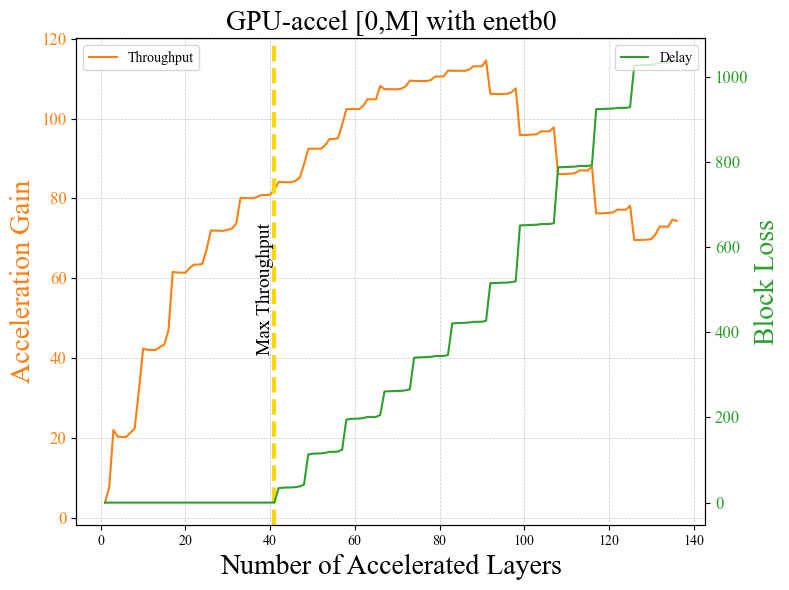

In [470]:
# num_accelerated_layer_list를 기준으로 정렬
sorted_data = sorted(zip(num_accelerated_layer_list, acceleration_gain_list, block_time_list))

# 정렬된 데이터 분리
sorted_num_accelerated_layer_list, sorted_acceleration_gain_list, sorted_block_time_list = zip(*sorted_data)

# 2개의 y축을 가지는 그래프 생성
fig, ax1 = plt.subplots(figsize=(8, 6))

# 첫 번째 y축 (total_execution_time_list)
color = "tab:orange"
ax1.set_ylabel("Acceleration Gain", color=color, size=20)
ax1.set_xlabel("Number of Accelerated Layers", size=20)

ax1.plot(sorted_num_accelerated_layer_list, sorted_acceleration_gain_list, color=color, linestyle="-", label="Throughput")
ax1.tick_params(axis="y", labelcolor=color, labelsize=12)
ax1.legend(loc="upper left")

# 두 번째 y축 (throughput_list)
ax2 = ax1.twinx()
color = "tab:green"
ax2.set_xlabel("Layer index", size=20)
ax2.set_ylabel("Block Loss", color=color, size=20)
ax2.plot(sorted_num_accelerated_layer_list, sorted_block_time_list, color=color, linestyle="-", label="Delay")
ax2.tick_params(axis="y", labelcolor=color, labelsize=12)
ax2.legend(loc="upper right")

ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
ax1.axvline(x=corresponding_delay_num_of_accelerated_layers, color="gold", linewidth=3, linestyle="--")
ax1.text(corresponding_delay_num_of_accelerated_layers, np.max(sorted_acceleration_gain_list) / 2, "Max Throughput", color="black", rotation=90, 
         verticalalignment="center", horizontalalignment="right", fontsize=14)

plt.title(f"GPU-accel [0,M] with {mode}", size=20)
plt.tight_layout()
plt.show()

# print("num_accelerated_layer_list: ", num_accelerated_layer_list)
# print("acceleration_gain_list: ", sorted_acceleration_gain_list)
# print("block_time_list: ", sorted_block_time_list)

# Net Gain = Acceleration Gain - Block Loss

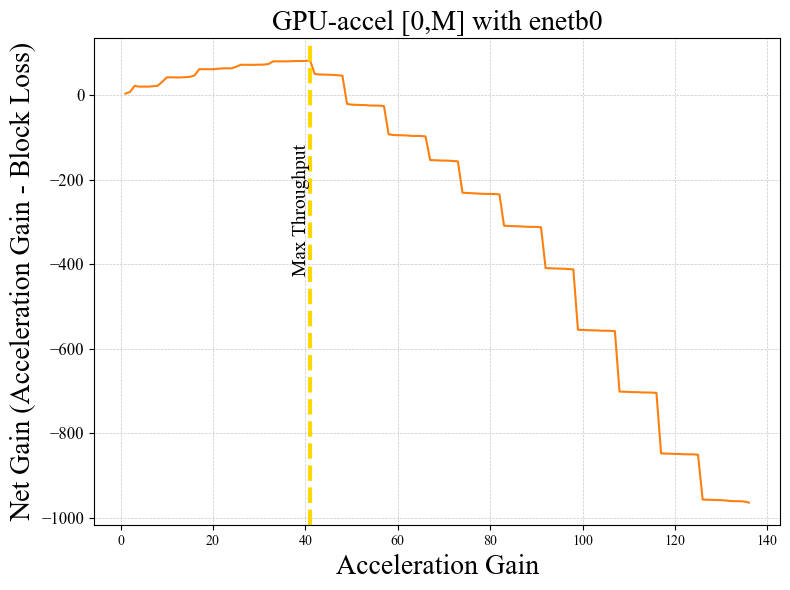

In [472]:
# num_accelerated_layer_list를 기준으로 정렬
sorted_data = sorted(zip(num_accelerated_layer_list, acceleration_gain_list, block_time_list))

# 정렬된 데이터 분리
sorted_num_accelerated_layer_list, sorted_acceleration_gain_list, sorted_block_time_list = zip(*sorted_data)
net_gain_list = [a - b for a, b in zip(sorted_acceleration_gain_list, sorted_block_time_list)]

# 2개의 y축을 가지는 그래프 생성
fig, ax1 = plt.subplots(figsize=(8, 6))

# 첫 번째 y축 (total_execution_time_list)
color = "tab:orange"
ax1.set_xlabel("Acceleration Gain", size=20)
ax1.set_ylabel("Net Gain (Acceleration Gain - Block Loss)", size=20)
ax1.plot(sorted_num_accelerated_layer_list, net_gain_list, color=color, linestyle="-", label="Throughput")
ax1.tick_params(axis="y", labelsize=12)

ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

ax1.axvline(x=corresponding_delay_num_of_accelerated_layers, color="gold", linewidth=3, linestyle="--")
ax1.text(corresponding_delay_num_of_accelerated_layers, np.mean(net_gain_list), "Max Throughput", color="black", rotation=90, 
         verticalalignment="center", horizontalalignment="right", fontsize=14)


plt.title(f"GPU-accel [0,M] with {mode}", size=20)
plt.tight_layout()
plt.show()

# print("num_accelerated_layer_list: ", num_accelerated_layer_list)
# print("net_gain_list: ", net_gain_list)

# X축 1개, Y축 1개

MAX Throughput Index: 40
MAX Throughput: 60.27415828821548
Corresponding Number of Accelerated Layers: 41
Corresponding Delay: 151.53799924812483


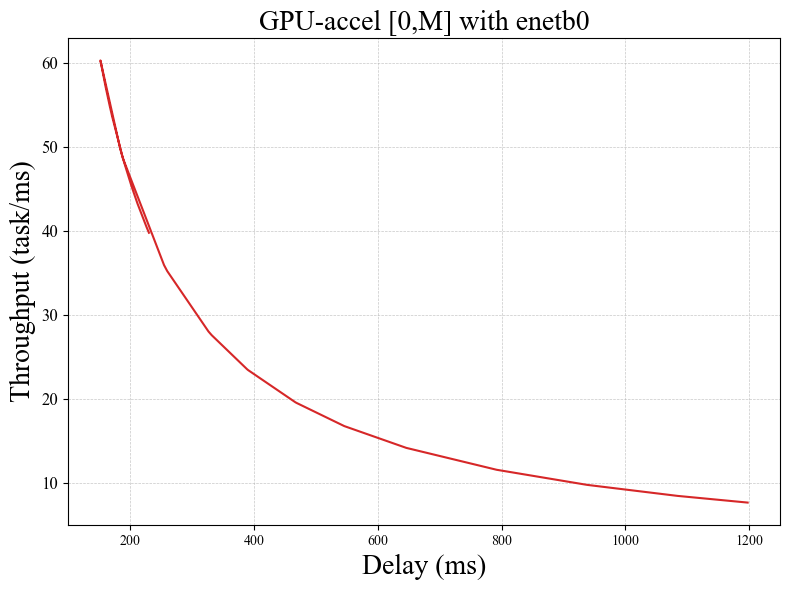

In [474]:
# num_accelerated_layer_list를 기준으로 정렬
sorted_data = sorted(zip(num_accelerated_layer_list, max_execution_time_list, throughput_list))

# 정렬된 데이터 분리
sorted_num_accelerated_layer_list, sorted_max_execution_time_list, sorted_throughput_list = zip(*sorted_data)

# MAX throughput과 그때의 delay 계산 및 출력
max_throughput = max(sorted_throughput_list)
max_throughput_index = sorted_throughput_list.index(max_throughput)
corresponding_delay = sorted_max_execution_time_list[max_throughput_index]
corresponding_delay_num_of_accelerated_layers = sorted_num_accelerated_layer_list[max_throughput_index]

print("MAX Throughput Index:", max_throughput_index)
print("MAX Throughput:", max_throughput)
print("Corresponding Number of Accelerated Layers:", corresponding_delay_num_of_accelerated_layers)
print("Corresponding Delay:", corresponding_delay)


# 2개의 y축을 가지는 그래프 생성
fig, ax1 = plt.subplots(figsize=(8, 6))

color = "tab:red"
ax1.set_ylabel("Throughput (task/ms)", size=20)
ax1.set_xlabel("Delay (ms)", size=20)
ax1.plot(sorted_max_execution_time_list, sorted_throughput_list, color=color, linestyle="-", label="Throughput")
ax1.tick_params(axis="y", labelsize=12)

ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)


plt.title(f"GPU-accel [0,M] with {mode}", size=20)
plt.tight_layout()
plt.show()

# print("num_accelerated_layer_list: ", num_accelerated_layer_list)
# print("max_execution_time_list: ", max_execution_time_list)
# print("throughput_list: ", throughput_list)

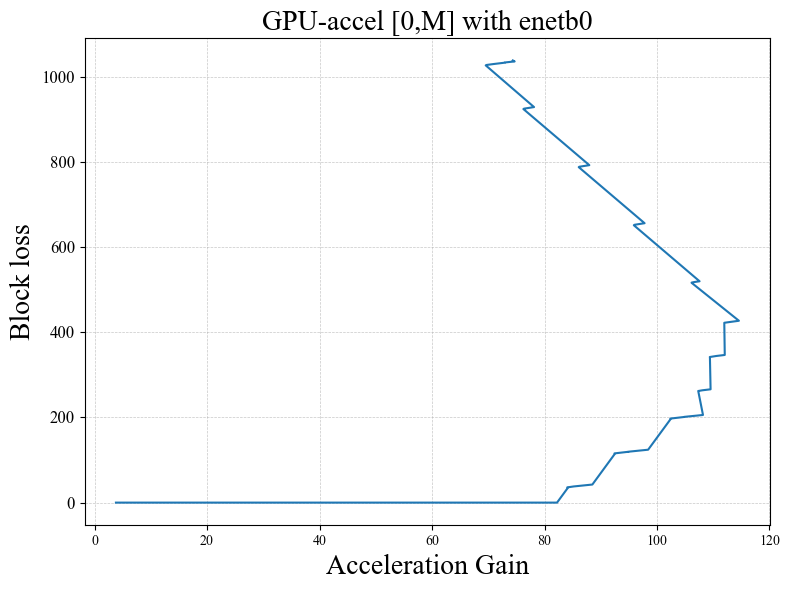

In [475]:
# num_accelerated_layer_list를 기준으로 정렬
sorted_data = sorted(zip(num_accelerated_layer_list, acceleration_gain_list, block_time_list))

# 정렬된 데이터 분리
sorted_num_accelerated_layer_list, sorted_acceleration_gain_list, sorted_block_time_list = zip(*sorted_data)

# 2개의 y축을 가지는 그래프 생성
fig, ax1 = plt.subplots(figsize=(8, 6))

# 첫 번째 y축 (total_execution_time_list)
color = "tab:blue"
ax1.set_ylabel("Block loss", size=20)
ax1.set_xlabel("Acceleration Gain", size=20)
ax1.plot(sorted_acceleration_gain_list, sorted_block_time_list, color=color, linestyle="-", label="Throughput")
ax1.tick_params(axis="y", labelsize=12)
ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.title(f"GPU-accel [0,M] with {mode}", size=20)
plt.tight_layout()
plt.show()

# print("num_accelerated_layer_list: ", num_accelerated_layer_list)
# print("acceleration_gain_list: ", sorted_acceleration_gain_list)
# print("block_time_list: ", sorted_block_time_list)

# 기본 그래프

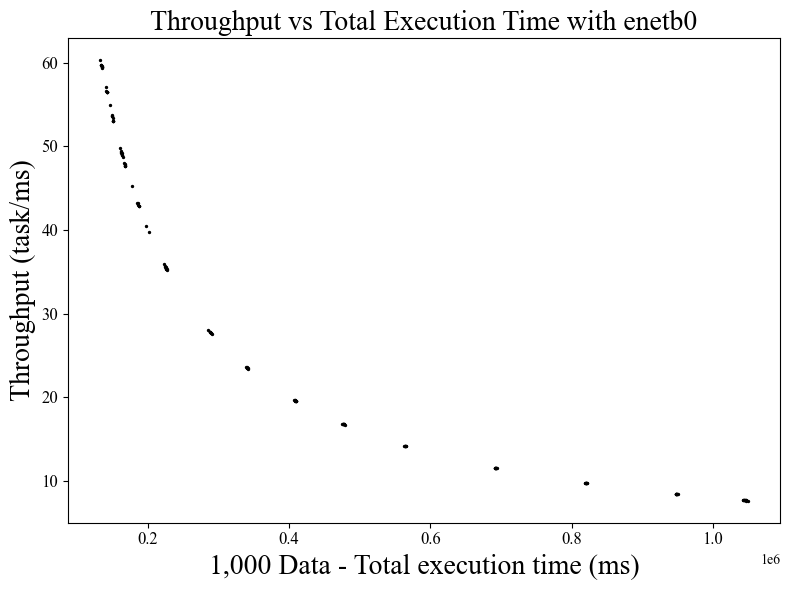

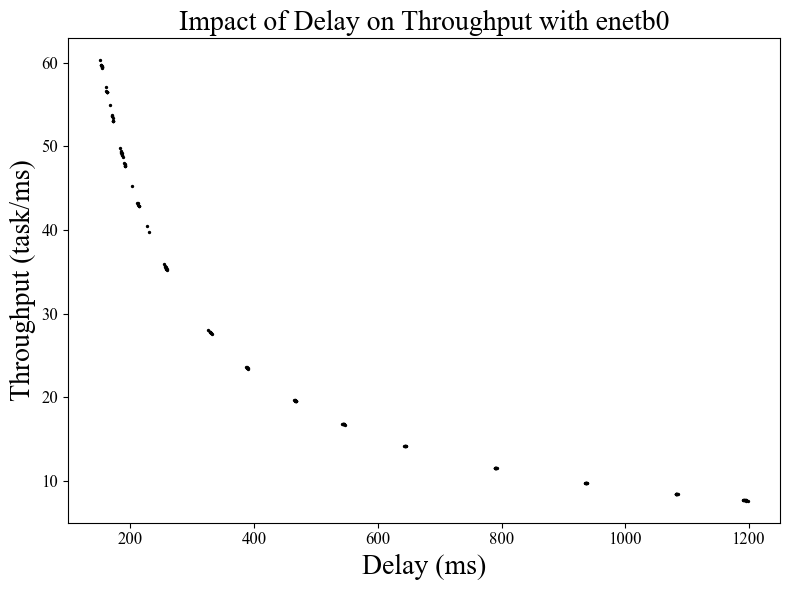

In [481]:
# Set up the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

color = "black"
ax1.scatter(total_execution_time_list, throughput_list, color=color, s= 2)

ax1.set_xlabel('1,000 Data - Total execution time (ms)', size=20)
ax1.set_ylabel("Throughput (task/ms)", size=20)

ax1.tick_params(axis='both', labelsize=12)
plt.title(f"Throughput vs Total Execution Time with {mode}", fontsize=20)
plt.tight_layout()
plt.show()

# Set up the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

color = "black"
ax1.scatter(avg_execution_time_list, throughput_list, color=color, s= 2)

ax1.set_xlabel('Delay (ms)', size=20)
ax1.set_ylabel("Throughput (task/ms)", size=20)

ax1.tick_params(axis='both', labelsize=12)
plt.title(f"Impact of Delay on Throughput with {mode}", fontsize=20)

plt.tight_layout()
plt.show()

In [482]:
# [0,M] & [start, M] 구성 찾기
all_results = []

# 모든 start 값에 대한 배열 생성
for start in range(0, 1):
    result = []
    for i in range(start, layer_num-2):
        row = [0] + [0] * start + [1] * (i - start + 1) + [0] * (layer_num -2 - (i + 1)) + [0]
        result.append(row)
    all_results.append(result)

# 각 배열이 acceleration_type에서 몇 번째 인덱스에 있는지 저장
all_results_indexes = []

for result in all_results:
    result_indexes = []
    for row in result:
        # row를 튜플로 변환하여 acceleration_type에서의 인덱스 확인
        index = acceleration_type.index(row)
        result_indexes.append(index)
    all_results_indexes.append(result_indexes)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135


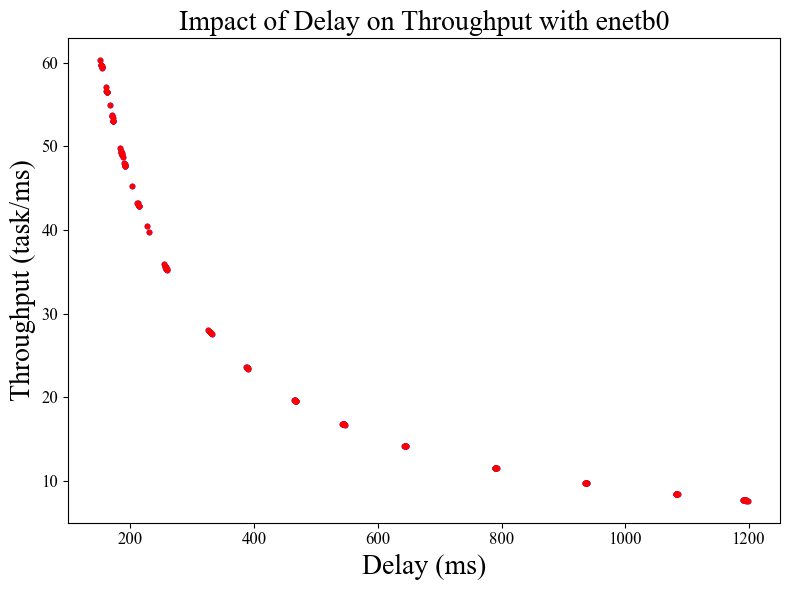

In [483]:
# Set up the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

color = "black"
ax1.scatter(max_execution_time_list, throughput_list, color=color, zorder=-start, s=2)

# all_results_indexes에 있는 점들을 파란색으로 추가
for indexes in all_results_indexes:
    for idx in indexes:
        ax1.scatter(max_execution_time_list[idx], throughput_list[idx], color='blue', s=10, zorder=1)

# start = 0인 애들은 빨간색으로 한 번 더 찍기
for idx in all_results_indexes[0]:  # all_results_indexes[0]이 start=0에 해당하는 인덱스들임
    print(idx)
    ax1.scatter(max_execution_time_list[idx], throughput_list[idx], color='red', s=10, zorder=2)

# Delay에는 Block time이 포함됨
ax1.set_xlabel('Delay (ms)', size=20)
ax1.set_ylabel("Throughput (task/ms)", size=20)
ax1.tick_params(axis='both', labelsize=12)
plt.title(f"Impact of Delay on Throughput with {mode}", fontsize=20)

plt.tight_layout()
plt.show()

In [484]:
# throughput_list에서 최대값, 해당 인덱스, 그리고 max_execution_time_list 값을 찾기
max_throughput = max(throughput_list)
max_index = throughput_list.index(max_throughput)
corresponding_execution_time = max_execution_time_list[max_index]
corresponding_acceleration_type = acceleration_type[max_index]

# 결과 출력
print(f"최대 Throughput 값: {max_throughput}")
print(f"최대 Throughput이 발생한 인덱스: {max_index}")
print(f"해당 인덱스의 avg_execution_time: {corresponding_execution_time}")
print(f"해당 인덱스의 acceleration_type: {corresponding_acceleration_type}")

print(len(corresponding_acceleration_type))
print(corresponding_acceleration_type)

# 합 계산
total_inference_time = sum(
    cpu_inference_list[i] if corresponding_acceleration_type[i] == 0 else gpu_inference_list[i]
    for i in range(len(corresponding_acceleration_type))
)

# 결과 출력
total_cpu_time = sum(cpu_inference_list)
acceleration_gain = total_cpu_time - total_inference_time
print(f"\n전체 CPU 실행 inference 시간: {total_cpu_time}")
print(f"최종 합산된 inference 시간: {total_inference_time}")
print(f"가속 이득: {acceleration_gain}")
block_time = max_execution_time-total_inference_time
print(f"블락 손실: {block_time}")

최대 Throughput 값: 60.27415828821548
최대 Throughput이 발생한 인덱스: 40
해당 인덱스의 avg_execution_time: 151.53799924812483
해당 인덱스의 acceleration_type: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
138
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

전체 CPU 실행 inference 시간: 233.7

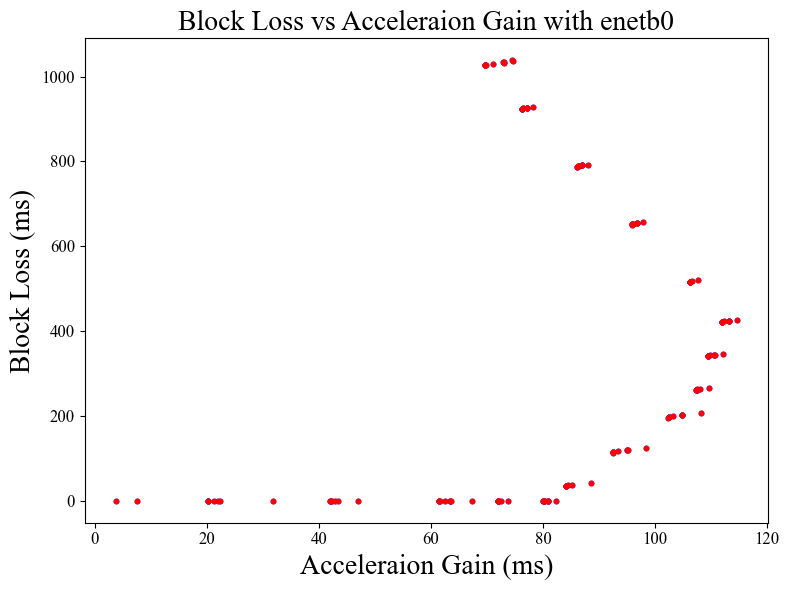

136
최대 acceleration_gain_list 값: 114.56938646616562
최대 acceleration_gain_list 발생한 인덱스: 90
해당 인덱스의 block_time_list: 427.0633375940162
해당 인덱스의 acceleration_type: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [485]:
# Set up the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

color = "black"
ax1.scatter(acceleration_gain_list, block_time_list, color=color, zorder=-start, s=2)

# all_results_indexes에 있는 점들을 파란색으로 추가
for indexes in all_results_indexes:
    for idx in indexes:
        ax1.scatter(acceleration_gain_list[idx], block_time_list[idx], color='blue', s=10, zorder=1)

# start = 0인 애들은 빨간색으로 한 번 더 찍기
for idx in all_results_indexes[0]:  # all_results_indexes[0]이 start=0에 해당하는 인덱스들임
    ax1.scatter(acceleration_gain_list[idx], block_time_list[idx], color='red', s=10, zorder=2)


ax1.set_xlabel('Acceleraion Gain (ms)', size=20)
ax1.set_ylabel("Block Loss (ms)", size=20)
ax1.tick_params(axis='both', labelsize=12)
plt.title(f"Block Loss vs Acceleraion Gain with {mode}", fontsize=20)

plt.tight_layout()
plt.show()

print(len(throughput_list))

# throughput_list에서 최대값, 해당 인덱스, 그리고 max_execution_time_list 값을 찾기
max_throughput = max(acceleration_gain_list)
max_index = acceleration_gain_list.index(max_throughput)
corresponding_execution_time = block_time_list[max_index]
corresponding_acceleration_type = acceleration_type[max_index]

# 결과 출력
print(f"최대 acceleration_gain_list 값: {max_throughput}")
print(f"최대 acceleration_gain_list 발생한 인덱스: {max_index}")
print(f"해당 인덱스의 block_time_list: {corresponding_execution_time}")
print(f"해당 인덱스의 acceleration_type: {corresponding_acceleration_type}")


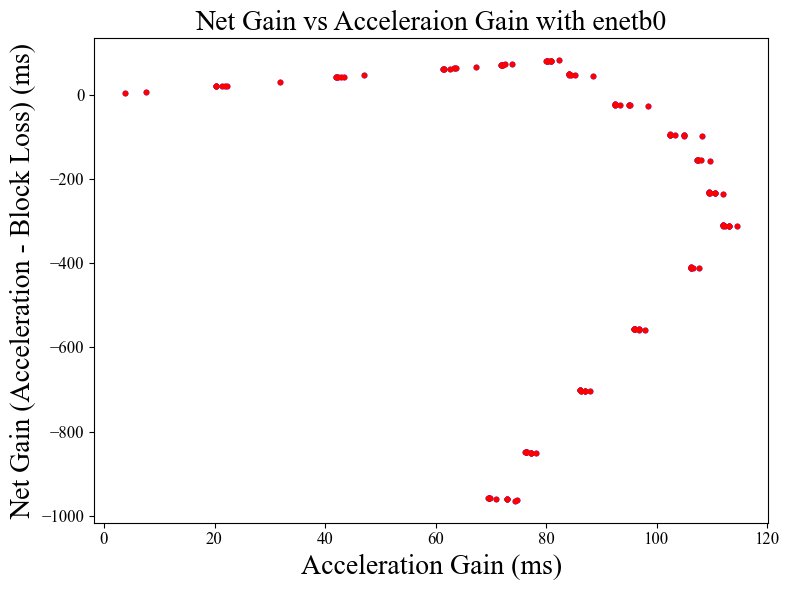

최대 acceleration_gain - block_time 값: 82.22278646616104
최대값 발생한 인덱스: 40
해당 인덱스의 acceleration_gain: 82.22278646616556
해당 인덱스의 block_time: 4.519051799434237e-12


In [486]:
# acceleration_gain - block_time 계산
loss_difference = [acc - block for acc, block in zip(acceleration_gain_list, block_time_list)]

# Set up the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# 흑색으로 전체 데이터 점 표현
color = "black"
ax1.scatter(acceleration_gain_list, loss_difference, color=color, zorder=-start, s=2)

# all_results_indexes에 있는 점들을 파란색으로 추가
for indexes in all_results_indexes:
    for idx in indexes:
        ax1.scatter(acceleration_gain_list[idx], loss_difference[idx], color='blue', s=10, zorder=1)

# start = 0인 애들은 빨간색으로 한 번 더 찍기
for idx in all_results_indexes[0]:  # all_results_indexes[0]이 start=0에 해당하는 인덱스들임
    ax1.scatter(acceleration_gain_list[idx], loss_difference[idx], color='red', s=10, zorder=2)

# 축 라벨 및 설정
ax1.set_xlabel('Acceleration Gain (ms)', size=20)
ax1.set_ylabel('Net Gain (Acceleration - Block Loss) (ms)', size=20)
ax1.tick_params(axis='both', labelsize=12)
plt.title(f"Net Gain vs Acceleraion Gain with {mode}", fontsize=20)

# 그래프 표시
plt.tight_layout()
plt.show()

# 최대 acceleration_gain - block_time 값을 찾기
max_difference = max(loss_difference)
max_index = loss_difference.index(max_difference)
corresponding_acceleration_gain = acceleration_gain_list[max_index]
corresponding_block_time = block_time_list[max_index]

# 결과 출력
print(f"최대 acceleration_gain - block_time 값: {max_difference}")
print(f"최대값 발생한 인덱스: {max_index}")
print(f"해당 인덱스의 acceleration_gain: {corresponding_acceleration_gain}")
print(f"해당 인덱스의 block_time: {corresponding_block_time}")


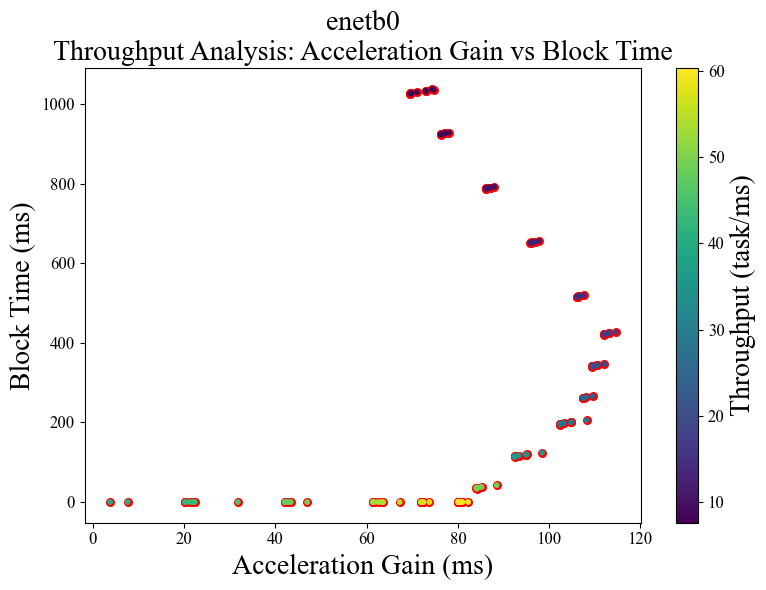

최대 throughput 값: 60.27415828821548
최대 throughput 발생한 인덱스: 40
해당 인덱스의 acceleration_gain: 82.22278646616556
해당 인덱스의 block_time: 4.519051799434237e-12


In [487]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Normalize throughput_list for color mapping
norm_throughput = (throughput_list - np.min(throughput_list)) / (np.max(throughput_list) - np.min(throughput_list))

# Scatter plot with z-axis represented by colors
scatter = ax1.scatter(
    acceleration_gain_list, 
    block_time_list, 
    c=throughput_list, # norm_throughput
    cmap='viridis',  # Choose a color map
    s=10,  # Adjust size of points
    zorder=1
)

# Colorbar for throughput values
cbar = fig.colorbar(scatter, ax=ax1)
cbar.set_label('Throughput (task/ms)', size=20)
cbar.ax.tick_params(labelsize=12)

# start=0 points highlighted in red
for idx in all_results_indexes[0]:  # Points corresponding to start=0
    ax1.scatter(acceleration_gain_list[idx], block_time_list[idx], color='red', s=30, zorder=-100)

# Axis labels
ax1.set_xlabel('Acceleration Gain (ms)', size=20)
ax1.set_ylabel('Block Time (ms)', size=20)
ax1.tick_params(axis='both', labelsize=12)
plt.title(f"{mode}\nThroughput Analysis: Acceleration Gain vs Block Time", fontsize = 20)
plt.tight_layout()
plt.show()

# Maximum throughput analysis
max_throughput = max(throughput_list)
max_index = throughput_list.index(max_throughput)
corresponding_acceleration_gain = acceleration_gain_list[max_index]
corresponding_block_time = block_time_list[max_index]

# Results output
print(f"최대 throughput 값: {max_throughput}")
print(f"최대 throughput 발생한 인덱스: {max_index}")
print(f"해당 인덱스의 acceleration_gain: {corresponding_acceleration_gain}")
print(f"해당 인덱스의 block_time: {corresponding_block_time}")


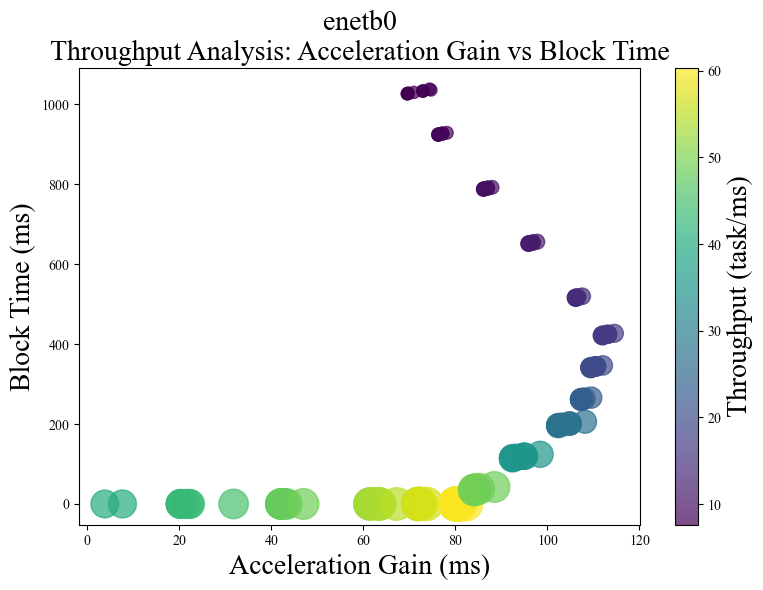

In [488]:
fig, ax = plt.subplots(figsize=(8, 6))

# Bubble Chart
scatter = ax.scatter(
    acceleration_gain_list, 
    block_time_list, 
    s=np.array(throughput_list) * 10,  # 크기를 throughput_list로 설정
    c=throughput_list, 
    cmap='viridis', 
    alpha=0.7
)

# Colorbar
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Throughput (task/ms)', size=20)
plt.title(f"{mode}\nThroughput Analysis: Acceleration Gain vs Block Time", fontsize = 20)
# Labels
ax.set_xlabel('Acceleration Gain (ms)', size=20)
ax.set_ylabel('Block Time (ms)', size=20)

plt.tight_layout()
plt.show()


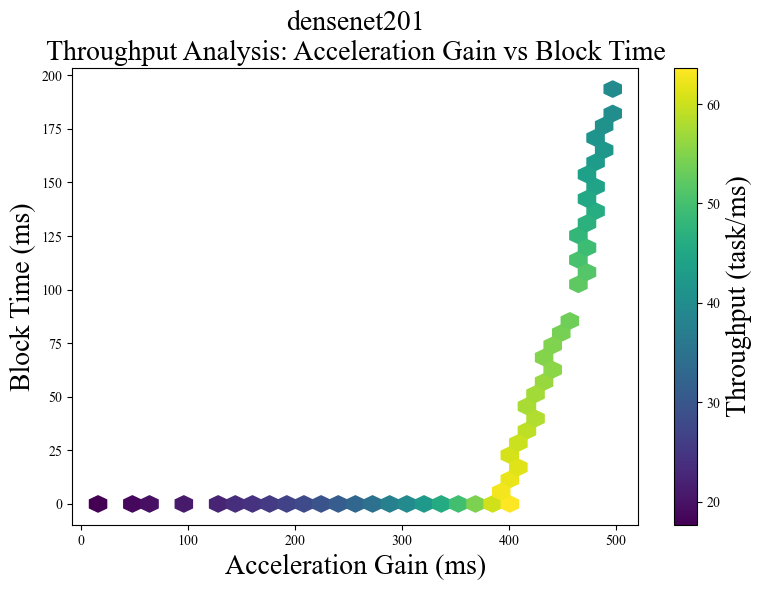

In [428]:
fig, ax = plt.subplots(figsize=(8, 6))

# Hexbin Plot
hb = ax.hexbin(
    acceleration_gain_list, 
    block_time_list, 
    C=throughput_list, 
    gridsize=30, 
    cmap='viridis'
)

# Colorbar
cbar = fig.colorbar(hb, ax=ax)
cbar.set_label('Throughput (task/ms)', size=20)
plt.title(f"{mode}\nThroughput Analysis: Acceleration Gain vs Block Time", fontsize = 20)
# Labels
ax.set_xlabel('Acceleration Gain (ms)', size=20)
ax.set_ylabel('Block Time (ms)', size=20)

plt.tight_layout()
plt.show()


# 히스토그램

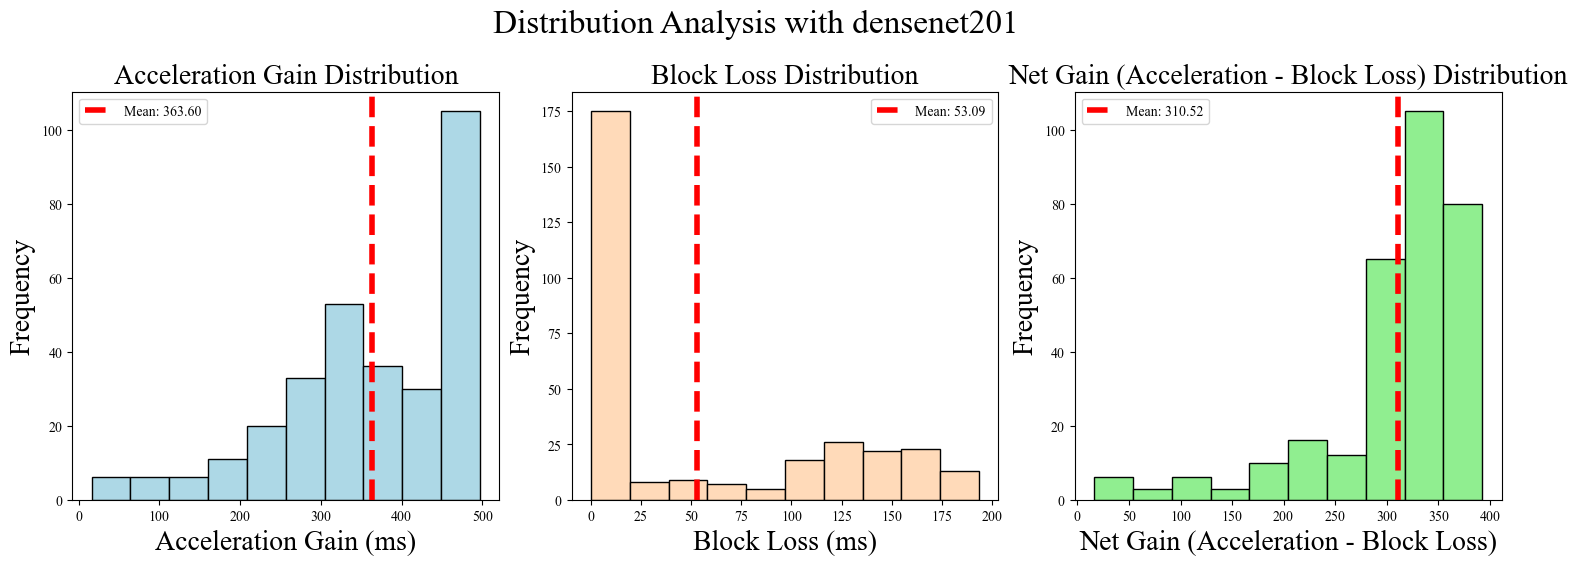

In [434]:
# 평균값 계산
acceleration_mean = np.mean(acceleration_gain_list)
block_mean = np.mean(block_time_list)
loss_mean = np.mean(loss_difference)

# 서브플롯 생성
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# 첫 번째 히스토그램 (연한 파랑)
axes[0].hist(acceleration_gain_list, bins=10, edgecolor='black', color='lightblue')
axes[0].axvline(x=acceleration_mean, color='red', linestyle='--', label=f'Mean: {acceleration_mean:.2f}', linewidth=4)
axes[0].set_title("Acceleration Gain Distribution", fontsize=20)
axes[0].set_xlabel("Acceleration Gain (ms)", fontsize=20)
axes[0].set_ylabel("Frequency", fontsize=20)
axes[0].legend()

# 두 번째 히스토그램 (연한 주황)
axes[1].hist(block_time_list, bins=10, edgecolor='black', color='peachpuff')
axes[1].axvline(x=block_mean, color='red', linestyle='--', label=f'Mean: {block_mean:.2f}', linewidth=4)
axes[1].set_title("Block Loss Distribution", fontsize=20)
axes[1].set_xlabel("Block Loss (ms)", fontsize=20)
axes[1].set_ylabel("Frequency", fontsize=20)
axes[1].legend()

# 세 번째 히스토그램 (연한 초록)
axes[2].hist(loss_difference, bins=10, edgecolor='black', color='lightgreen')
axes[2].axvline(x=loss_mean, color='red', linestyle='--', label=f'Mean: {loss_mean:.2f}', linewidth=4)
axes[2].set_title("Net Gain (Acceleration - Block Loss) Distribution", fontsize=20)
axes[2].set_xlabel("Net Gain (Acceleration - Block Loss)", fontsize=20)
axes[2].set_ylabel("Frequency", fontsize=20)
axes[2].legend()

# 그래프 출력
fig.suptitle(f"Distribution Analysis with {mode}", fontsize=24, y=1.1)
plt.show()